**NOTE: This notebook is written for the Google Colab platform, which provides free hardware acceleration. However it can also be run (possibly with minor modifications) as a standard Jupyter notebook, using a local GPU.**

Also, this notebook is inspired by ideas from a [blog](https://www.pyimagesearch.com/2018/07/09/face-clustering-with-python/) by Adrian Rosebrock at [pyimagesearch.com](pyimagesearch.com). Definitely check out their other blogs: they have some great stuff there.

In [1]:
#@title -- Installation of Packages -- { display-mode: "form" }
import sys
# !{sys.executable} -m pip install google-images-download
!{sys.executable} -m pip install face_recognition lapjv
!wget -nc https://raw.githubusercontent.com/ultralytics/google-images-download/master/bing_scraper.py
# install dependencies for ultralytics bing_scraper
!{sys.executable} -m pip install tqdm selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
sys.path.insert(0, '/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd.get("https://www.webite-url.com")

     |████████████████████████████████| 100.2MB 42kB/s 
  Created wheel for lapjv: filename=lapjv-1.3.1-cp36-cp36m-linux_x86_64.whl size=83725 sha256=62b35367f6789647efc5fd0d31353fb42e70f9142618ca91df14a228ace69df8
  Stored in directory: /root/.cache/pip/wheels/6e/fe/fd/b700bd67e00bcd65241d55d875eec17892a86ca6a4deef9515
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=49fef161c1f42dcaca5b11a03db4489c4833d94d2979d88a1c5ab399cf9e7868
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built lapjv face-recognition-models
--2020-05-15 12:04:41--  https://raw.githubusercontent.com/ultralytics/google-images-download/master/bing_scraper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... conn

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: use options instead of chrome_options


In [0]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
# from google_images_download.google_images_download import googleimagesdownload
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from imutils import build_montages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from lapjv import lapjv
from umap import UMAP
import face_recognition
from PIL import Image
import numpy as np
import glob
import dlib
import os

In [3]:
#@title -- Downloading Data -- { display-mode: "form" }
!mkdir -p data
!wget -nc -O data/george_martin_example.jpg https://www.dropbox.com/s/i5kxprnwuqg4s95/george_martin_example.jpg?dl=1

--2020-05-15 12:07:11--  https://www.dropbox.com/s/i5kxprnwuqg4s95/george_martin_example.jpg?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/i5kxprnwuqg4s95/george_martin_example.jpg [following]
--2020-05-15 12:07:12--  https://www.dropbox.com/s/dl/i5kxprnwuqg4s95/george_martin_example.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1c09756271bcac689190a72982.dl.dropboxusercontent.com/cd/0/get/A3w9bsqZmpzCDLrVGWe41D_i4t2IezhglQjE758shQVfFqIGQY4q1PRdG7H3N_NU-9rje3o7b9xnLysBluj_Evslm5o3k7mBmbY1rtLwHRbCPPKt8jh7iwktrAoF4NEMtHE/file?dl=1# [following]
--2020-05-15 12:07:13--  https://uc1c09756271bcac689190a72982.dl.dropboxusercontent.com/cd/0/get/A3w9bsqZmpzCDLrVGWe41D_i4t2IezhglQjE758shQVfFqIGQY4q1PRdG7H3N_NU-9rje3o7b

In [0]:
#@title -- Auxiliary Functions -- { display-mode: "form" }
!mkdir -p output

# def download_images(keyword, limit, num_retries=5,
#                     output_directory='downloads',
#                     image_directory='.'):
#     for i in range(num_retries):
#         response = googleimagesdownload()
#         download = response.download(
#             {"keywords": k, "limit": 25,
#              "output_directory": output_directory,
#              "image_directory": image_directory})
#         absolute_image_paths = list(download[0].values())[0]

#         if len(absolute_image_paths) > 0:
#             break

# def init_dlib():
#     face_recognition.api.cnn_face_detector = dlib.cnn_face_detection_model_v1(face_recognition.api.cnn_face_detection_model)
#     face_recognition.api.face_encoder = dlib.face_recognition_model_v1(face_recognition.api.face_recognition_model)

# def clean_dlib():
#     del face_recognition.api.cnn_face_detector 
#     del face_recognition.api.face_encoder

def download_images(keyword, limit, num_retries=5,
                    output_directory='downloads',
                    image_directory='.', chromedriver=None):
    if chromedriver is None:
        chromedriver = '/usr/lib/chromium-browser/chromedriver'

    command = ('python3 bing_scraper.py --search "{keyword:}" --limit 25 ' + 
              '--download --chromedriver {chromedriver:} ' +
              '--output_directory="{output_directory:}" ' +
              '--image_directory="{image_directory:}" ' 
    ).format(keyword=keyword, chromedriver=chromedriver,
             output_directory=output_directory,
             image_directory=image_directory)

    !$command

def get_image_filenames(
    directory,
    image_exts = ['.jpg', '.jpeg', '.png', '.gif'],
    recursive = True
):
    images = []
    
    for fname in glob.glob(os.path.join(directory, "**/*"), recursive=recursive):
        if os.path.isfile(fname) and os.path.splitext(fname)[-1] in image_exts:
            images.append(fname)
    
    return images

def detect_faces(img_path, detection_method="cnn"):
    img = Image.open(img_path)
    ar = np.array(img.convert(mode="RGB"))
    bboxes = face_recognition.face_locations(ar,
                  model=detection_method)

    fig = plt.figure(figsize=(10, 8))
    ax = plt.gca()
    plt.imshow(ar)
    plt.axis("off")

    for top, right, bottom, left in bboxes:
        box = patches.Rectangle(
            (left, top),
            width=right-left,
            height=bottom-top,
            linewidth=3, edgecolor='r',
            facecolor='none'
        )

        ax.add_patch(box)
    
    return fig

def enforce_maxres(img, maxres):
    width, height = img.width, img.height
    
    if width > height:
        if width > maxres:
            width, height = maxres, maxres / width * height
            img = img.resize((int(width), int(height)), resample=3)
    else:
        if height > maxres:
            width, height = maxres / height * width, maxres
            img = img.resize((int(width), int(height)), resample=3)
            
    return img

def encode_image(img, img_path,
                 detection_method="cnn",
                 maxres=1800):
    """
    detection_method: "cnn" or "hog"
    """
    img = enforce_maxres(img, maxres)
    ar = np.array(img.convert(mode="RGB"))

    # find the bounding boxes of all the faces
    # using the specified detection method
    bboxes = face_recognition.face_locations(ar,
                  model=detection_method)

    # compute the embeddings for all the faces,
    # given their bounding boxes
    encs = face_recognition.face_encodings(ar, bboxes)

    # for each face record the image path, image shape,
    # the face's bounding box and encoding
    return [{
        "img_path": img_path,
        "img_shape": np.shape(ar),
        "bbox": bbox,
        "enc": enc
    } for (bbox, enc) in zip(bboxes, encs)]
    
def encode_dataset(dataset_path, detection_method,
                   verbose=1, maxres=1200):
    img_paths = get_image_filenames(dataset_path)
    data = []
    
    for (i, img_path) in enumerate(img_paths):
        if verbose:
            print("Processing image {}/{}".format(i + 1,
                len(img_paths)))
            print(img_path)

        try:
            img = Image.open(img_path)

        except IOError:
            if verbose:
                print("Skipping '{}'; the file cannot be opened.".format(
                        imagePath))
            continue

        img_encs = encode_image(img, img_path,
                      detection_method=detection_method,
                      maxres=maxres)
        data.extend(img_encs)

    if verbose:
        print("Found the total of {} face boxes.".format(len(data)))

    return data

def extract_face(img_path, img_shape, bbox):
    img = Image.open(img_path)
    img = img.resize((img_shape[1], img_shape[0]), resample=3)
    ar = np.array(img.convert(mode="RGB"))

    (top, right, bottom, left) = bbox
    face = ar[top:bottom, left:right]

    return np.array(Image.fromarray(face).resize((96, 96), resample=3))

def plot_clusters(data, clusts, labelIDs,
                  verbose=1, figsize=(10, 8),
                  show_title=True):
    figures = []

    # loop over the unique face integers
    for labelID in labelIDs:
        # find all indexes into the `data` array that belong to the
        # current label ID, then randomly sample a maximum of 25 indexes
        # from the set
        if verbose:
            print("Faces for face ID: {}".format(labelID))
        
        idxs = np.where(clusts == labelID)[0]
        idxs = np.random.choice(idxs, size=min(25, len(idxs)),
            replace=False)
    
        # initialize the list of faces to include in the montage
        faces = [extract_face(
                    data[i]["img_path"],
                    data[i]["img_shape"],
                    data[i]["bbox"]
                ) for i in idxs]
    
        # create a montage using 96x96 "tiles" with 5 rows and 5 columns
        montage = build_montages(faces, (96, 96), (5, 5))[0]
        
        # show the output montage
        title = "Face ID #{}".format(labelID)
        title = "Unknown Faces" if labelID == -1 else title
        
        fig = plt.figure(figsize=figsize)
        plt.imshow(montage)
        plt.axis('off')

        if show_title:
            plt.title(title)

        figures.append(fig)

    return figures

def plot_faces(data, poses, w=0.08, h=0.08, ax=None):
    ax = plt.gca()
    
    for i in range(len(data)):
        face = extract_face(data[i]['img_path'],
                            data[i]["img_shape"],
                            data[i]["bbox"])
        pos = poses[i]
        ax.imshow(face, extent=[pos[0] - w/2, pos[0] + w/2,
                                pos[1] - h/2, pos[1] + h/2])

    plt.xlim([np.min(poses[:, 0]) - w, np.max(poses[:, 0]) + w])
    plt.ylim([np.min(poses[:, 1]) - h, np.max(poses[:, 1]) + h])

# Human Face Clustering

The notebook will show a simple way to peform face clustering in Python. The code is vased on the [blog](https://www.pyimagesearch.com/2018/07/09/face-clustering-with-python/) of Adrian Rosebrock.

We will start by defining a couple of auxiliary functions, to which we will later refer. Since some of these are a bit verbose, the code of the following cell is hidden.

## Parameters

We define a few necessary parameters, such as the path to the data etc.

In [0]:
# Path to the folder, that will contain the images.
dataset_path = "dataset"

# The face detection method: "cnn" or "hog".
# CNN is more precise, but HoG is a bit faster,
# especially without GPU acceleration.
detection_method = "cnn"

# The number of parallel threads to be used in the
# clustering algorithm (-1 means that all available
# cores are to be used).
num_jobs = -1

---

## Task 1: Downloading the Images

Naturally, if we want to do face clustering, we will need some face images. We will therefore use the ``googleimagesdownload`` package to download a few images from the Google Images service – e.g. the photos of some famous celebrities.

**Add the names of 5 or 6 celebrities into the ``keywords`` list below. These will be used as keywords when searching for the photos.**

---

In [0]:
keywords = ['ariana grande', 'marcelo rebelo de sousa', 'john green', 'benedict cumberbatch', 'emma watson']

For every one of these keywords, we will now download a couple of images and store them in the ``downloads`` folder.

In [16]:
for k in keywords:
    download_images(keyword=k, limit=25, output_directory=dataset_path)

Searching for https://www.bing.com/images/search?q=ariana%20grande
1/25 https://peopledotcom.files.wordpress.com/2018/12/ariana-grande-11.jpg 
2/25 https://cdn-img.instyle.com/sites/default/files/images/2018/06/gettyimages-627683818.jpg 
3/25 https://www.hawtcelebs.com/wp-content/uploads/2019/08/ariana-grande-in-psychologies-magazine-uk-september-2019-0.jpg 
4/25 https://i.pinimg.com/736x/4a/90/59/4a9059317055146005efd484fb9706cf.jpg 
5/25 https://celebmafia.com/wp-content/uploads/2018/06/ariana-grande-the-fader-magazine-summer-2018-17.jpg 
6/25 https://www.calendarclub.co.uk/-/media/productimages/24/41/244136_main.jpg 
7/25 https://s2.r29static.com/bin/entry/c9a/0,0,2000,1050/x,80/2012831/image.jpg 
8/25 http://7wallpapers.net/wp-content/uploads/1_Ariana-Grande.jpg 
9/25 https://celebmafia.com/wp-content/uploads/2016/11/ariana-grande-hairspray-live-press-junket-in-universal-city-11-16-2016-22.jpg 
10/25 https://celebmafia.com/wp-content/uploads/2018/08/ariana-grande-nicki-minaj-and-ca

Should the image download fail for any reason, uncomment the cell below to download a precollected dataset.

In [0]:
# !wget -nc -O faceclust_dataset.zip https://www.dropbox.com/s/3mkdxof3r4rmmf2/faceclust_dataset.zip?dl=1
# !unzip -oq -d dataset faceclust_dataset.zip

## Extraction and Transformation of Faces

Given that the images we are using are downloaded directly from Google Images, they will contain not only human faces, but also entire figures and other objects. We will need to extract the faces somehow. If we opted in for ``detection_method = "cnn"`` before, a method based on convolutional neural networks will be used. Let us see what the results might look like using a sample image.

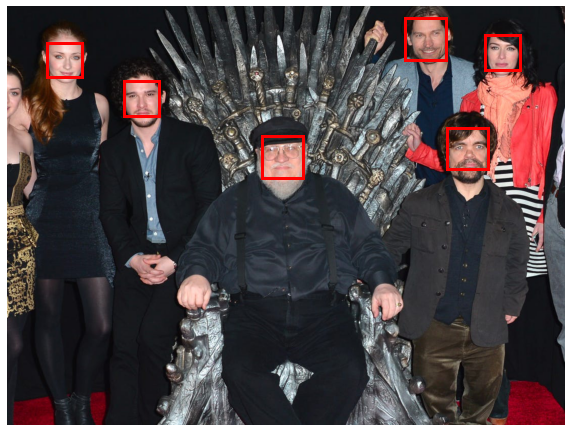

In [19]:
fig = detect_faces("data/george_martin_example.jpg",
                   detection_method="cnn")
fig.savefig("output/face_detection_cnn.jpg",
            bbox_inches="tight", pad_inches=0)

If we use ``detection_method="hog"``, face detection will slightly be faster, but less robust.

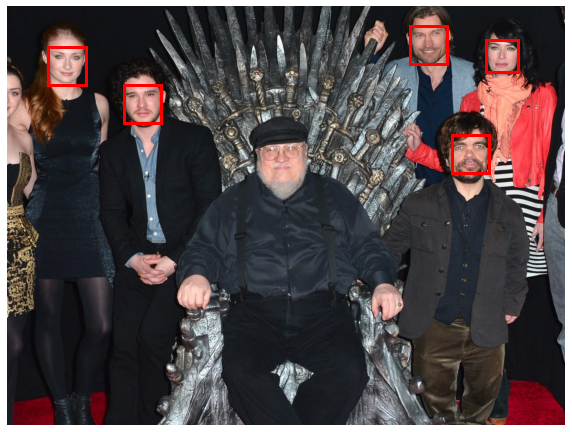

In [11]:
fig = detect_faces("data/george_martin_example.jpg",
                   detection_method="hog")
fig.savefig("output/face_detection_hog.jpg",
            bbox_inches="tight", pad_inches=0)

In a subsequent step, we will use a different deep neural network to transform our facial images into a new representation that will better express the similarities and differences between human faces than a raw-pixel representation could. The network is pretrained using a dataset with many human faces, using the scheme shown in the figure.

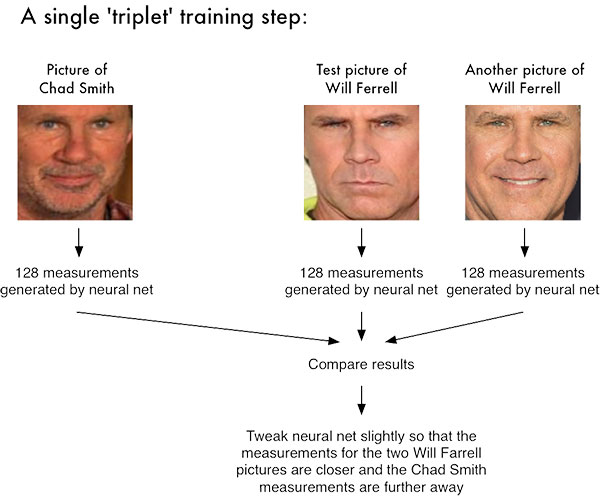

Each face is transformed into a 128-dimensional vector. During training, the network will be presented with a set of 3 images. Two of them will be different photos of the same person, while the third one will be a photo of a different person. The network's task will be to minimize the difference between the representations of the same person and maximize the difference between representations of different persons.

In [44]:
data = encode_dataset(dataset_path, detection_method)

Processing image 1/172
dataset/emma_watson/1.1-21.jpg
Processing image 2/172
dataset/emma_watson/22.emma-watson-the-ny-film-society-for-kids-at-lincoln-center-s-beale-theater-3-13-2017-1.jpg
Processing image 3/172
dataset/emma_watson/12.Emma+Watson+photo.filmcelebritiesactresses.blogspot-864.jpg
Processing image 4/172
dataset/emma_watson/7.emma-watson-2014-6_1e18a472209f2c73c3032efbc33f9a1a.today-ss-slide-desktop.jpg
Processing image 5/172
dataset/emma_watson/14.Emma+Watson+photo.filmcelebritiesactresses.blogspot-627.jpg
Processing image 6/172
dataset/emma_watson/3.emma-watson-2009-03_1e18a472209f2c73c3032efbc33f9a1a.today-ss-slide-desktop.jpg
Processing image 7/172
dataset/emma_watson/5.emma-watson-photoshoot-february-2017-3.jpg
Processing image 8/172
dataset/emma_watson/11.Emma+Watson+photo.filmcelebritiesactresses.blogspot-140.jpg
Processing image 9/172
dataset/emma_watson/15.emma-watson-superba-in-venice-08-17-2019-9.jpg
Processing image 10/172
dataset/emma_watson/25.emma-watson-10

Our dataset may contain faces of people whose names were not among our keywords (the original photos might have contained other persons). Some faces may be extracted incorrectly and there is a chance that some non-faces will be extracted by mistake as well. It will be interesting to see how the network extracting the representations will be able to cope with this.

In [0]:
data = np.array(data)
encodings = [d["enc"] for d in data]

---

## Task 2: Clustering

**Apply clustering to the ``encodings`` array, e.g. using DBSCAN. Assign the resulting cluster IDs to variable clusts.**

---

In [0]:
# apply the clustering

dbscan = DBSCAN(eps=0.45, min_samples = 5)
clusts = dbscan.fit_predict(encodings)

## Displaying the Results

Finally, let's visualize the faces belonging to the individual clusters. The first image will correspond to faces that do not belong into any cluster.

In [53]:
labelIDs = np.unique(clusts)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("Number of unique faces: {}".format(numUniqueFaces))
print("The photos were found using {} different keywords.".format(len(keywords)))

Number of unique faces: 5
The photos were found using 5 different keywords.


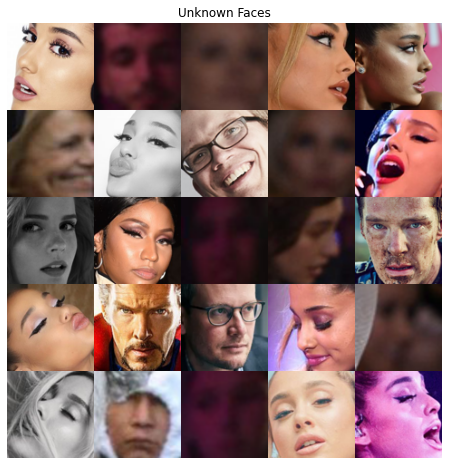

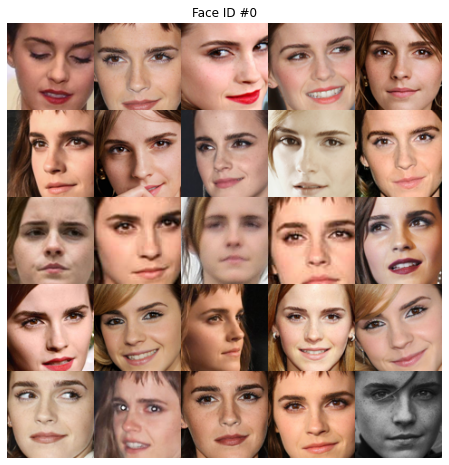

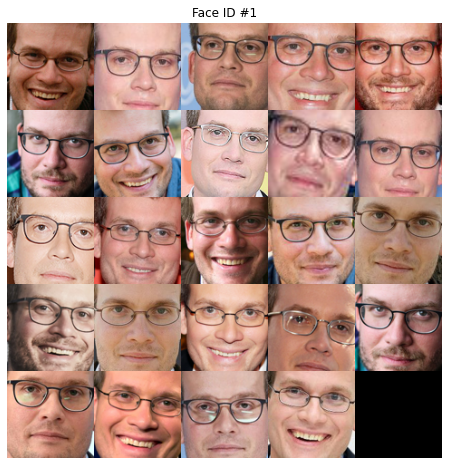

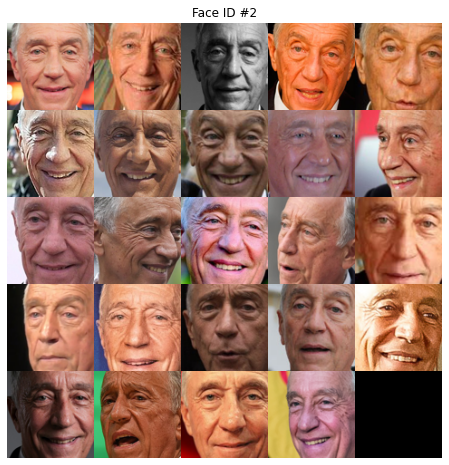

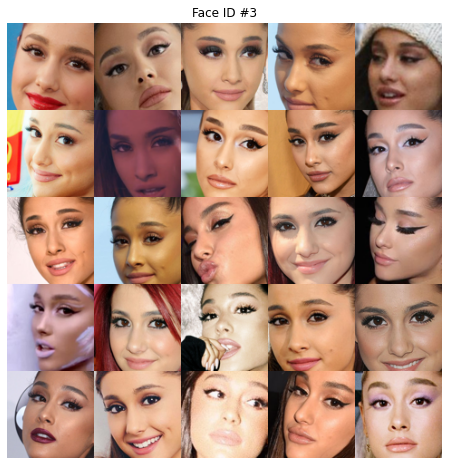

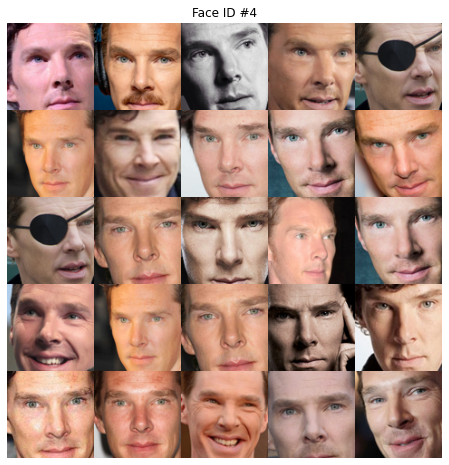

In [54]:
figs = plot_clusters(data, clusts, labelIDs, verbose=0)

for ifig, fig in enumerate(figs):
    fig.savefig("output/clust_{}.pdf".format(ifig),
                bbox_inches="tight", pad_inches=0)

---

## Task 3: Reducing Dimensionality using UMAP

**Use UMAP to reduce the dimensionality of the data in the ``encodings`` array from 128 to 2 – so that it is possible to plot the data. It may be necessary to tweak arguments ``min_dist`` and ``spread`` to get a nice, readable figure (i.e. avoid excessive face overlap and such). Assign the results to an array named ``embeds``.**

---

In [86]:



# apply dimensionality reduction

um = UMAP(n_components=2, min_dist = 8, spread =9)

embeds =  um.fit_transform(encodings)        # assign the reduced data to this variable





/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1157: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


We normalize the reduced data into the range of [0, 1].

In [0]:
embeds -= embeds.min(axis=0)
embeds /= embeds.max(axis=0)

We plot the faces on the embedding positions.

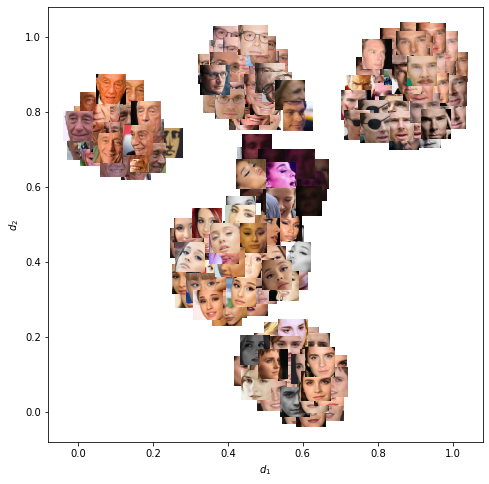

In [88]:
plt.figure(figsize=(10, 8))
plot_faces(data, embeds)
plt.xlabel('$d_1$')
plt.ylabel('$d_2$')

plt.savefig("output/faces_umap.pdf",
            bbox_inches="tight", pad_inches=0)

## Displaying the Faces on a Grid using the Jonker-Volgenant Algorithm

The visualization produced by UMAP displays the distances between face clusters and such. However, the images overlap to a considerable extent, which makes the figure less readable. We can therefore take an additional step and project all the images into a regular grid using the Jonker-Volgenant algorithm.

In [0]:
sqrt_size = int(np.ceil(np.sqrt(len(embeds))))
size = sqrt_size * sqrt_size
grid = np.dstack(np.meshgrid(np.linspace(0, 1, sqrt_size), np.linspace(0, 1, sqrt_size))).reshape(-1, 2)

padded_embeds = np.zeros((size, embeds.shape[1]))
padded_embeds[:embeds.shape[0], :] = embeds

cost_matrix = cdist(grid, padded_embeds, "sqeuclidean").astype(np.float32)
cost_matrix = cost_matrix * (100000 / cost_matrix.max())
row_as, col_as, _ = lapjv(cost_matrix)
grid_jv = grid[col_as]

The new positions have been stored in array ``grid_jv``: we will now use them for the plotting.

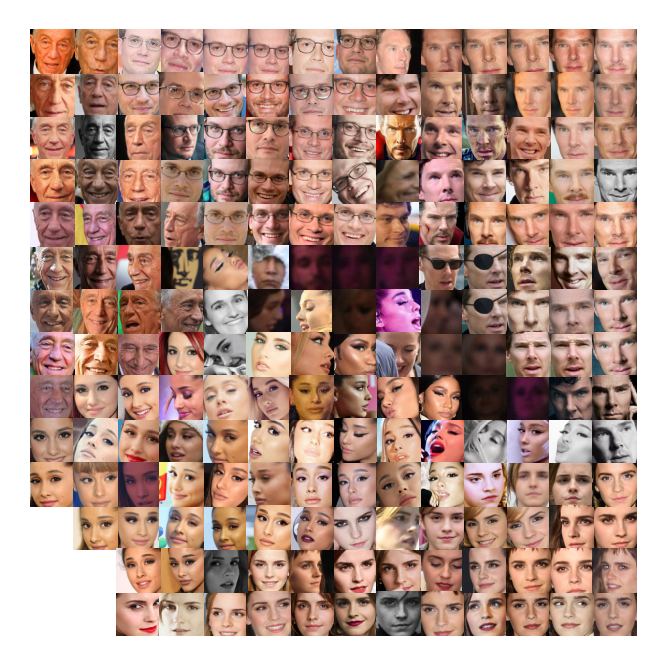

In [90]:
plt.figure(figsize=(12, 12))
plot_faces(data, grid_jv)
plt.axis('off')
plt.savefig("output/faces_grid.pdf",
            bbox_inches="tight", pad_inches=0)